# Data Exploration (Part VI - Complaint Type & Location Exploration)
## Intro
In our last post, we looked at some time based fields. Summer months are big for incidents, so are the 1st, 10th, 15th, and 20th of the month. Why? We're not sure yet, maybe with some more exploration, we'll get to the bottom of that.

Let's load up our data from S3 again.

In [1]:
import os
os.system("sudo pip install findspark sql_magic pyspark_dist_explore")

0

In [2]:
# Use findspark package to connect Jupyter to Spark shell
import findspark
findspark.init('/usr/lib/spark')

# Load SparkSession object
import pyspark
from pyspark.sql import SparkSession

# Load other libraries
from datetime import datetime
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
from functools import reduce
import pandas as pd
import numpy as np

# Graphing with matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Initiate SparkSession as "spark"
spark = SparkSession\
    .builder\
    .getOrCreate()

# Load sql_magic and connect to Spark
%load_ext sql_magic
%config SQL.conn_name = 'spark'

In [3]:
%%time
# Read NYPD Complaint Data
df_filtered = spark.read.parquet("s3n://2017edmfasatb/nypd_complaints/data/df_filtered.parquet")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 14.2 s


In [4]:
df_filtered.count()

5336177

In [5]:
df_filtered.printSchema()

root
 |-- COMPLAINT_NUMBER: integer (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP: timestamp (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP: timestamp (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP: timestamp (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_YEAR: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_MONTH: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_DAY: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_WEEKDAY: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_HOUR: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_YEAR: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_MONTH: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_DAY: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_WEEKDAY: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_HOUR: string (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP_YEAR: string (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP_MONTH: string (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP_DAY:

Quick note to remind ourselves that we've already filtered down the dataset at this point based on some data cleansing critieria:
- Complaint start date must be between 2006 and 2016, inclusive
- Complaint length must be between 0 and 365 days, inclusive

Records not within these bounds are likely to contain a typo / have data quality issues.

## Offense Types
We already took a look at complaint types a bit when we were cleaning up the OFFENSE\_DESCRIPTION column of our data set. Let's review what that looks like. We should have something like 10 categories that we've summarized our incidents under.

In [6]:
# Add table to SQL Context
df_filtered.createOrReplaceTempView("df_filtered")

In [7]:
offense_description_result = %read_sql \
SELECT \
    OFFENSE_DESCRIPTION, \
    COUNT(*) AS NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY \
    OFFENSE_DESCRIPTION

Query started at 08:03:43 PM UTC; Query executed in 0.08 m

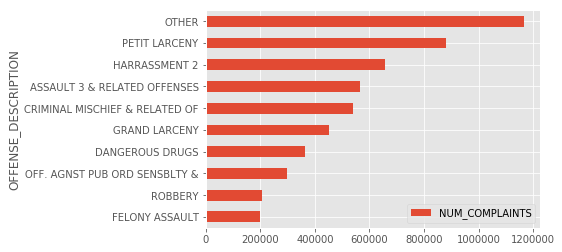

In [8]:
# Plot types of offenses
offense_description_result.sort_values('NUM_COMPLAINTS', ascending = True).plot(kind = 'barh', x = 'OFFENSE_DESCRIPTION', y = 'NUM_COMPLAINTS')

Right, we've seen this before. Petit Larceny takes the cake, followed by Harrassment, Assault, Mischief, and the rest of the gang. Let's move on. Let's take a look at the amount of incidents that were of the different OFFENSE\_LEVELs.

In [9]:
offense_description_result = %read_sql \
SELECT \
    OFFENSE_DESCRIPTION, \
    OFFENSE_LEVEL, \
    OFFENSE_RESULT, \
    COUNT(*) AS NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY \
    OFFENSE_DESCRIPTION, \
    OFFENSE_LEVEL, \
    OFFENSE_RESULT

Query started at 08:03:49 PM UTC; Query executed in 0.14 m

In [10]:
# Prepare dataframe for stacked bar chart
offense_description_result_melted = offense_description_result.pivot_table(
    values = 'NUM_COMPLAINTS',
    index = 'OFFENSE_DESCRIPTION',
    columns = 'OFFENSE_LEVEL',
    aggfunc = np.sum
).fillna(0).reset_index()

In [11]:
# Add back total offenses column
offense_description_result_melted['NUM_COMPLAINTS'] = offense_description_result_melted['FELONY'] +\
    offense_description_result_melted['MISDEMEANOR'] +\
    offense_description_result_melted['VIOLATION']

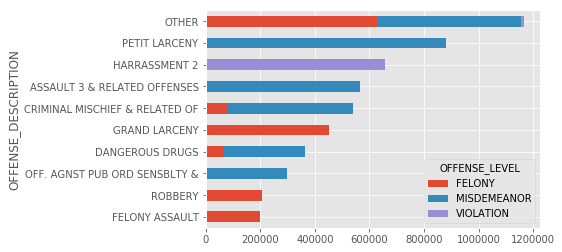

In [12]:
# Plot stacked bar chart
offense_description_result_melted.sort_values('NUM_COMPLAINTS', ascending = True).plot(kind = 'barh', x = 'OFFENSE_DESCRIPTION', y = ['FELONY', 'MISDEMEANOR', 'VIOLATION'], stacked = True)

Here, we can get some more insight into the nature of offenses. Again, violations, misdemeanors, and felonies can be broken out by the following criteria:

>- VIOLATION - Punishable by up to 15 days in jail
- MISDEMEANOR - Punishable by between 15 days and 1 year in jail
- FELONY - Punishable by over 1 year in jail

Harrassment is _**purely violation**_.

Petit Larceny, Assault, and Public Order offenses are _**purely misdemeanor**_.

Mischief and Drugs are _**largely misdemeanor**_ but _**border on felony**_.

Grand Larceny, Robbery, and Assault (Felony) are _**purely felony**_.

The only one I'd like to comment on here is Assault, because it shows up twice. One looks like 3rd degree Assault and less severe (misdemeanor), and one is more severe (felony). The misdemeanor Assault seems to be anything like a punch to the face, whereas the felony Assault can range anything from permenantly disfiguring a body part or putting the victim in substantial risk of death (e.g. gun shot?). Anyways, interesting to see what defines each of these offenses.

The only _**violation**_, seemingly in the entire dataset, is Harrassment. There is a few violations in _**OTHER**_, but that requires a deeper dive which I won't go into right now. Speaking of _**OTHER**_, it's a grouping that I'm trying to think of a better way to represent, but can't right now. It is a mix of misdemeanors and felonies, so it's difficult to profile OTHER. It doesn't help that it's got like 60 categories inside of it and is the largest category right now... Oh well, I don't want any more smaller categories so I'll leave it like this for now.

We also have one more field relating to offenses, let's take a look at whether or not the crime completed. I don't anticipate this will come in handy too much, but worth a look.

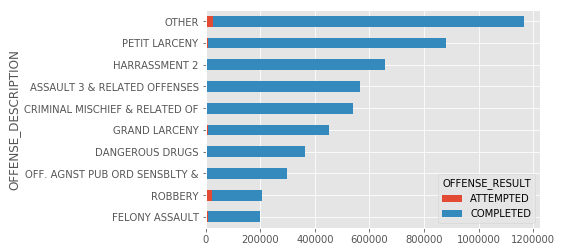

In [13]:
# Prepare dataframe for stacked bar chart
offense_description_result_melted = offense_description_result.pivot_table(
    values = 'NUM_COMPLAINTS',
    index = 'OFFENSE_DESCRIPTION',
    columns = 'OFFENSE_RESULT',
    aggfunc = np.sum
).fillna(0).reset_index()

# Add back total offenses column
offense_description_result_melted['NUM_COMPLAINTS'] = offense_description_result_melted['ATTEMPTED'] +\
    offense_description_result_melted['COMPLETED']
    
# Plot stacked bar chart
offense_description_result_melted.sort_values('NUM_COMPLAINTS', ascending = True).plot(kind = 'barh', x = 'OFFENSE_DESCRIPTION', y = ['ATTEMPTED', 'COMPLETED'], stacked = True)

Most of them are completed. I'm going to leave this for now. Actually, one quick graph just for my own satisfaction, how does OFFENSE\_RESULT look broken down by OFFENSE\_LEVEL?

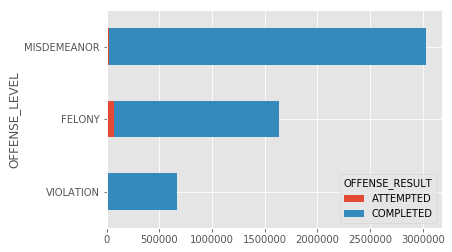

In [14]:
# Prepare dataframe for stacked bar chart
offense_description_result_melted = offense_description_result.pivot_table(
    values = 'NUM_COMPLAINTS',
    index = 'OFFENSE_LEVEL',
    columns = 'OFFENSE_RESULT',
    aggfunc = np.sum
).fillna(0).reset_index()

# Add back total offenses column
offense_description_result_melted['NUM_COMPLAINTS'] = offense_description_result_melted['ATTEMPTED'] +\
    offense_description_result_melted['COMPLETED']
    
# Plot stacked bar chart
offense_description_result_melted.sort_values('NUM_COMPLAINTS', ascending = True).plot(kind = 'barh', x = 'OFFENSE_LEVEL', y = ['ATTEMPTED', 'COMPLETED'], stacked = True)

That's actually what I expected.

<img src="http://www.reactiongifs.com/r/2013/11/vernon.gif" width="400">

No, but in all seriousness, a misdemeanor is probably much easier to pull off than a felony. In any case, though, such a wide majority of the offenses were completed, so OFFENSE\_RESULT will not be a focal point of my analysis.

### Jurisdiction
Pretty easy here, the JURISDICTION column 

In [15]:
jurisdiction_result = %read_sql SELECT \
    JURISDICTION, \
    COUNT(*) AS NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY JURISDICTION

Query started at 08:03:58 PM UTC; Query executed in 0.04 m

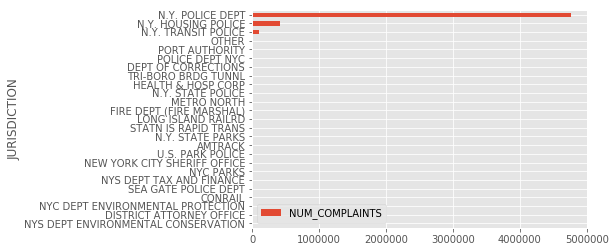

In [16]:
# Plot stacked bar chart
jurisdiction_result.sort_values('NUM_COMPLAINTS', ascending = True).plot(kind = 'barh', x = 'JURISDICTION', y = 'NUM_COMPLAINTS')

Essentially everything comes from a Police Department. Understood. Not much else to see here in my opinion. Next.

### Location
We've got a few location fields. One is definite latitude and longitude, and the other is a description of the environment. Let's look at the latter first.

In [17]:
premise_result = %read_sql \
SELECT \
    PREMISE_DESCRIPTION, \
    COUNT(*) AS NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY PREMISE_DESCRIPTION

Query started at 08:04:01 PM UTC; Query executed in 0.03 m

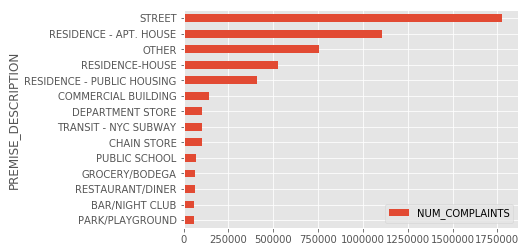

In [18]:
# Plot stacked bar chart
premise_result.sort_values('NUM_COMPLAINTS', ascending = True).plot(kind = 'barh', x = 'PREMISE_DESCRIPTION', y = 'NUM_COMPLAINTS')

#### Technology Sidenote: ggplot
I'd like to actually stop here and re-assess my graphing methods. In the "Offense Types" section, I created a few stacked bar charts. Matplotlib handles stacked barcharts in a really roundabout way... data usually comes in the following manner:

In [19]:
# Create sample dataframe
pd.DataFrame({
    'Name': ['John', 'John', 'Jane', 'Jane'],
    'Month': ['Jan', 'Feb', 'Jan', 'Feb'],
    'Violations': [1, 4, 7, 9]
})

,Month,Name,Violations
0,Jan,John,1
1,Feb,John,4
2,Jan,Jane,7
3,Feb,Jane,9


Every feature is generally in a single column with all the permutations of values within that column. However, if we wanted to create a stacked bar chart, we actually have to pivot the column that we'd like to stack first, like this:

In [20]:
# Create sample dataframe, pivoted
test_df = pd.DataFrame({
    'Name': ['John', 'Jane'],
    'Jan': [1, 7],
    'Feb': [4, 9]
})
test_df

,Feb,Jan,Name
0,4,1,John
1,9,7,Jane


Then, when graphing, we actually have to explicitly state all the columns we'd like to stack together, which in reality, is nothing but all the distinct values of _**one**_ column!

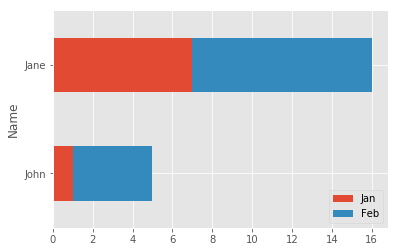

In [21]:
test_df.plot(kind = 'barh', x = 'Name', y = ['Jan', 'Feb'], stacked = True)

Where I'm going with this is, well, I'd like to add the **SPECIFIC\_LOCATION** in addition to PREMISE\_DESCRIPTION, and it totally makes sense to break out the PREMISE\_DESCRIPTION bar by SPECIFIC\_LOCATION, each with a different color. However, you could imagine if we actually wanted to do this in matplot lib, first we'd have to have _**1 column per distinct value of SPECIFIC LOCATION**_, we'd then have to _**explicitly assign all these columns to the y parameter in the Pandas plot() function**_. Not that this was a lot of work for us so far, but what if our column has like 20 distinct values? We're going to expand our dataframe by 20 columns and manually write 20 columns into our plot() function? It just seems a bit convoluted.

Here, I'm going to switch back to R to plot. When I wrote my [All-NBA prediction series](https://strikingmoose.com/2017/07/05/all_nba_predict_exploration_of_historical_nba_team_data/), I used ggplot2 to create many stacked barcharts, and I never felt it was too annoying to use. Let's try it again here.

#### Back To Location Exploration

In [34]:
premise_result = %read_sql \
SELECT \
    PREMISE_DESCRIPTION, \
    SPECIFIC_LOCATION, \
    COUNT(*) AS NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY \
    PREMISE_DESCRIPTION, \
    SPECIFIC_LOCATION

Query started at 08:16:29 PM UTC; Query executed in 0.24 m

In [52]:
# Replace nulls
premise_result = premise_result.fillna('')
premise_result.head()

,PREMISE_DESCRIPTION,SPECIFIC_LOCATION,NUM_COMPLAINTS
0,DEPARTMENT STORE,INSIDE,100349
1,RESIDENCE - APT. HOUSE,,11706
2,RESIDENCE - PUBLIC HOUSING,FRONT OF,91202
3,OTHER,FRONT OF,126235
4,PARK/PLAYGROUND,,6


We see that we have our data stored in columns here, the structure that makes the most sense to us right off the bat. Let's try to plot this in ggplot with each bar representing a PREMISE\_DESCRIPTION, and each bar divided and colored by SPECIFIC\_LOCATION

In [ ]:
# Install rpy2
os.system("sudo yum -y install R-devel")
os.system("sudo pip install rpy2")
%load_ext rpy2.ipython

In [26]:
%R install.packages('ggplot2')
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='<U9')

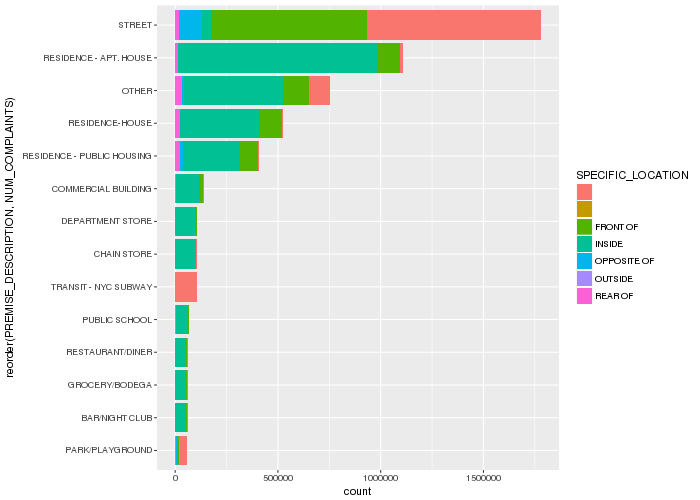

In [53]:
%%R -i premise_result -w 700 -h 500 -u px

ggplot(
    premise_result, 
    aes(
        x = reorder(PREMISE_DESCRIPTION, NUM_COMPLAINTS), 
        weight = NUM_COMPLAINTS,
        fill = SPECIFIC_LOCATION
    ),
)+ geom_bar() + coord_flip()

Here, we see a bit of a data quality issue - We have two blank values in the SPECIFIC\_LOCATION field. I'm not going to bother cleaning this because there is barely any of the bronze color. The rest looks good though! Only 5 distinct values really. Most are dominated by "INSIDE" with the exception on the street, which has lots of blank locations as well as "FRONT OF" and "OPPOSITE OF". This was interesting to see, but may not be so useful at the moment.

Last thing I'd like to take a look at is the long / lat stats. This one is a bit troublesome to me thinking about it because I'm not quite sure if I can actually plot 5M+ rows of data... our m4.large machine has 8GB memory, and our raw CSV was about 1.3GB, so theoretically, I think it can be done. Let's check the specs of our machine right now.

In [55]:
# Install and import psutil
os.system("sudo pip install psutil")
import psutil

In [60]:
# See free memory
psutil.virtual_memory()

svmem(total=8374710272, available=4359421952, percent=47.9, used=3763474432, free=633421824, active=5205327872, inactive=1835757568, buffers=463142912, cached=3514671104, shared=172032)

looks like we still have quite a bit of memory left, but if I think the process through, our raw dataframe is currently a _**SPARK**_ dataframe, distributed across the working memory of the entire cluster. If I want to bring it into the context of my _**R**_ application, which lives _**only on the master node like Python**_, I'll have to:
1. Use toPandas() to store the distributed Spark dataframe to a single-node memory Pandas dataframe
2. Use rpy2 to transfer the Pandas dataframe to an R dataframe

Here, I'd be replicating the dataset _**TWICE**_. Although our memory could handle it (our raw data set in CSV format was ~1.3GB, so adding two more of these may result in ~3GB), I don't think it's the best use of our memory, and definitely would not be able to scale easily.

There has to be a better way.

--The Next Day--

I came back to say, I think there's a good way, but unfortunately it's not Spark. Kinda ruins the spark run that I was on, but I honestly don't think there are plotting libraries for Spark! I'll continue with my plan in the next post.